In this notebook we want to predict Bitcoin price using python and machin learning (LSTM network)
SO first of all we will import the libraries that we want to use in this notebook

In [ ]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

Now Let's import our Dataframe. I used the `pd.DataReader()` library to import my dataframe. It's supper easy and fun :)

In [ ]:
df = web.DataReader('BTC-USD', data_source='yahoo', start='2014-01-01', end='2022-01-10')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-09-17,468.174011,452.421997,465.864014,457.334015,21056800,457.334015
2014-09-18,456.859985,413.104004,456.859985,424.440002,34483200,424.440002
2014-09-19,427.834991,384.532013,424.102997,394.795990,37919700,394.795990
2014-09-20,423.295990,389.882996,394.673004,408.903992,36863600,408.903992
2014-09-21,412.425995,393.181000,408.084991,398.821014,26580100,398.821014


In [ ]:
# Checking the shape of our original data frame
df.shape

(2674, 6)

Now let's plot our close price only. We wanna use the **dailty close price** of Bitcoin for our model in this notebook so we only plot **close price**

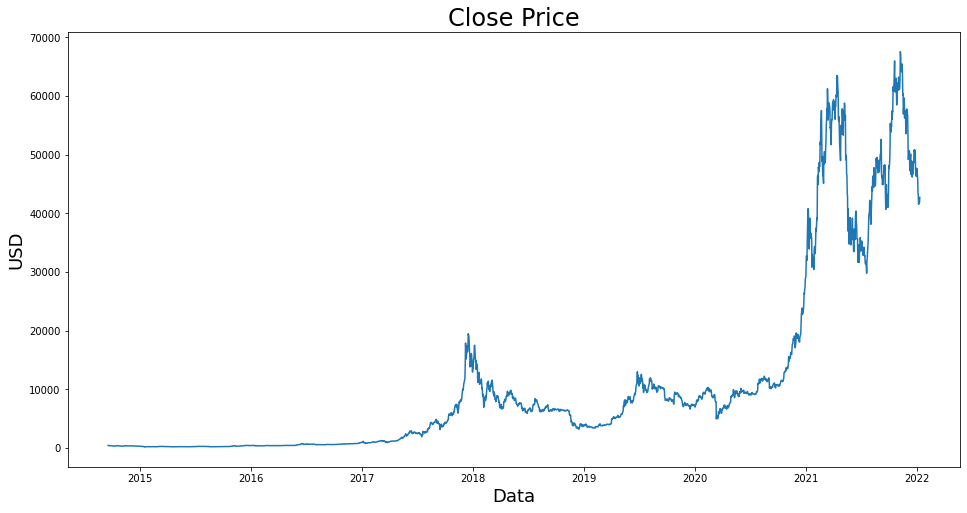

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Close Price', fontsize=24)
plt.plot(df['Close'])
plt.xlabel('Data', fontsize=18)
plt.ylabel('USD', fontsize=18)
plt.show()

So as we want to work only with Close Price, let's use `.filter` methode.
then we will import the values of the close price column in `data` variable to `dataset` variable.

In [ ]:
#Creat a new dataframe with only Close Price
data = df.filter(['Close'])
#Convert the dataframe to numpy array
dataset = data.values
# Get the number of rows to train the model on. we need this number to create our train and test sets
# math.ceil will round up the number
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training
training_data_len

2140

Now that we have our close price values in a seprated dataframe we can start normalization our data.

In [ ]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00414359],
       [0.00365546],
       [0.00321557],
       ...,
       [0.61929497],
       [0.61795439],
       [0.6315263 ]])

In this case, we can't use `train_test_split` function, because we need our train and test sets to be **Sequential Data**. LSTM network needs to have the *last output values* of network layer for the *input of the next layer* of network. So we can't use `train_test_split` and randomize our train/test data.

Our model will predict the price by looking the last 60 days of price. this will help our model to predict a better price and not just a random number that would have less than %50 accuracy. 

In [ ]:
# Creat the training dataset
train_data = scaled_data[0:training_data_len, :]
# Split the data into X_train and y_train data sets
X_train = []
y_train = []

for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])


  if i <= 60:
    print(X_train)
    print(y_train)
    print()

[array([0.00414359, 0.00365546, 0.00321557, 0.00342492, 0.0032753 ,
       0.00332473, 0.0038239 , 0.00363714, 0.00346454, 0.00335845,
       0.00328567, 0.00295417, 0.00292874, 0.00309905, 0.00304965,
       0.00292288, 0.00269198, 0.00223721, 0.00211322, 0.00225521,
       0.00234585, 0.00259445, 0.0027738 , 0.0027224 , 0.00273334,
       0.00297447, 0.00315054, 0.0033057 , 0.00321523, 0.00303393,
       0.00305177, 0.0031658 , 0.00313766, 0.00303822, 0.00309209,
       0.00304287, 0.00267573, 0.00267466, 0.00251033, 0.00262063,
       0.00259518, 0.00266387, 0.00233701, 0.00248116, 0.00237752,
       0.00219096, 0.00219308, 0.00221774, 0.00226134, 0.00239481,
       0.00254029, 0.00243827, 0.00248387, 0.00274766, 0.00280197,
       0.00281341, 0.00364242, 0.00360048, 0.00326041, 0.00293862])]
[0.0031129686946921404]



In [ ]:
len(X_train)

2080

So now X_train has 2083 array which any of them contains 60 days of price in them and y_train contains 2083 days of price which is the price of the last 60 days.

LSTM model needs the data to be an *array*. So here we will convert X_train and y_train to an array list.

In [ ]:
# Convert the X_train and y_train to numpy array
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
X_train.shape

(2080, 60)

By the way, LSTM needs the data to be inputet by 3 dimension. So we will reshape X_train to a 3-dim array

In [ ]:
# Reshape the data because LSTM needs 3 dim
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) # we make it like pros. it wanna say "np.reshape(X_train, (2083, 60, 1))"
X_train.shape

(2080, 60, 1)

Now that we finish creating our train data, we can create our *test data* (Just like how we did with train data).

In [ ]:
# Create the testing dataset
# Create a new array containing scaled values from index 2083
test_data = scaled_data[training_data_len - 60 : , :]

#Create the data sets X_test and y_test
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])


In [ ]:
# Convert the data to a numpy array 
X_test = np.array(X_test)

In [ ]:
# Reshape the test data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Here we getting to the fun part, **Creating the model**

We are using 2 layers of LSTM and 2 layers of Dense. Our first LSTM layer has `return_sequence=True` because our first and second layers are LSTM and we have to pass the output of the first layer to the second layer. (Again: **LSTM is a Network for Sequential Data**) 

Our last layer only has one unit in it while we need only one number (one price) to predict.

In [ ]:
# Build LSTM model
tf.random.set_seed(42)

model_1 = Sequential()
model_1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) , the simple form is "input_shape(60, 1)""
model_1.add(LSTM(50, return_sequences=False))
model_1.add(Dense(25))
model_1.add(Dense(1))

In [ ]:
# Compile the model
model_1.compile(optimizer='adam', loss='mse')

We will store the steps of each epochs in `history` variable. We are doing this to ploting the loss and finding the best number of epochs to avoid overfiting training.

Here we make a variable call `callback` which has the job to stop training the model whenever the *loss* is no longer decreasing.

(for more detail check the [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) library)

In [ ]:
# Train the model
import tensorflow as tf

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = model_1.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
2080/2080 [==============================] - 15s 6ms/step - loss: 2.0942e-04
Epoch 2/10
2080/2080 [==============================] - 13s 6ms/step - loss: 8.7422e-05
Epoch 3/10
2080/2080 [==============================] - 13s 6ms/step - loss: 6.1341e-05
Epoch 4/10
2080/2080 [==============================] - 13s 6ms/step - loss: 6.4308e-05
Epoch 5/10
2080/2080 [==============================] - 13s 6ms/step - loss: 5.6123e-05
Epoch 6/10
2080/2080 [==============================] - 13s 6ms/step - loss: 4.3052e-05
Epoch 7/10
2080/2080 [==============================] - 13s 6ms/step - loss: 4.6993e-05
Epoch 8/10
2080/2080 [==============================] - 13s 6ms/step - loss: 4.5506e-05
Epoch 9/10
2080/2080 [==============================] - 13s 6ms/step - loss: 4.1161e-05
Epoch 10/10
2080/2080 [==============================] - 12s 6ms/step - loss: 4.1789e-05


In [ ]:
# Get the model_1 predicted price values 
predictions_1 = model_1.predict(X_test)
predictions_1 = scaler.inverse_transform(predictions_1)
len(predictions_1)

534

In [ ]:
# Get the root mean squared error (RMSE) for model_1
rmse = np.sqrt(np.mean(predictions_1 - y_test)**2)
rmse

3303.5490457484784

Text(0.5, 0, 'epochs')

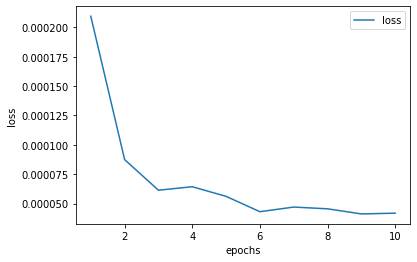

In [ ]:
# Let's plot the history of model_1 and see what's going on
historyForPlot = pd.DataFrame(history.history)
historyForPlot.index += 1 # we plus 1 to the number of indexing so our epochs Plot picture will be counting from 1 not 0.
historyForPlot.plot()
plt.ylabel("loss")
plt.xlabel("epochs")

As we can see, on epochs 6 and 10 we have the less loss and best scores. So we can train our model again with 6 epochs to see which one is better fiting.

In [ ]:
# Train the model again with 7 epochs
# but first we need to create another model so we can compare them together

# building LSTM model_2
tf.random.set_seed(42)

model_2 = Sequential()
model_2.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1))) # we made it like pros ;) | the simple form is "input_shape(60, 1)
model_2.add(LSTM(50, return_sequences=False))
model_2.add(Dense(25))
model_2.add(Dense(1))

# Compile model_2
model_2.compile(optimizer='Adam', loss='mse')

# Fit model_2
history_2 = model_2.fit(X_train, y_train, batch_size=1, epochs=6)

Epoch 1/6
2080/2080 [==============================] - 15s 6ms/step - loss: 2.0942e-04
Epoch 2/6
2080/2080 [==============================] - 12s 6ms/step - loss: 8.7422e-05
Epoch 3/6
2080/2080 [==============================] - 12s 6ms/step - loss: 6.1341e-05
Epoch 4/6
2080/2080 [==============================] - 12s 6ms/step - loss: 6.4308e-05
Epoch 5/6
2080/2080 [==============================] - 12s 6ms/step - loss: 5.6123e-05
Epoch 6/6
2080/2080 [==============================] - 12s 6ms/step - loss: 4.3052e-05


In [ ]:
# Get the model_2 predicted price values 
predictions_2 = model_2.predict(X_test)
predictions_2 = scaler.inverse_transform(predictions_2)
len(predictions_2)

534

In [ ]:
# Get the root mean squared error (RMSE) for model_2
rmse_2 = np.sqrt(np.mean(predictions_2 - y_test)**2)
rmse_2

5525.010594057233

Now let's see what did our models with predictions and compare our 2 models together:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


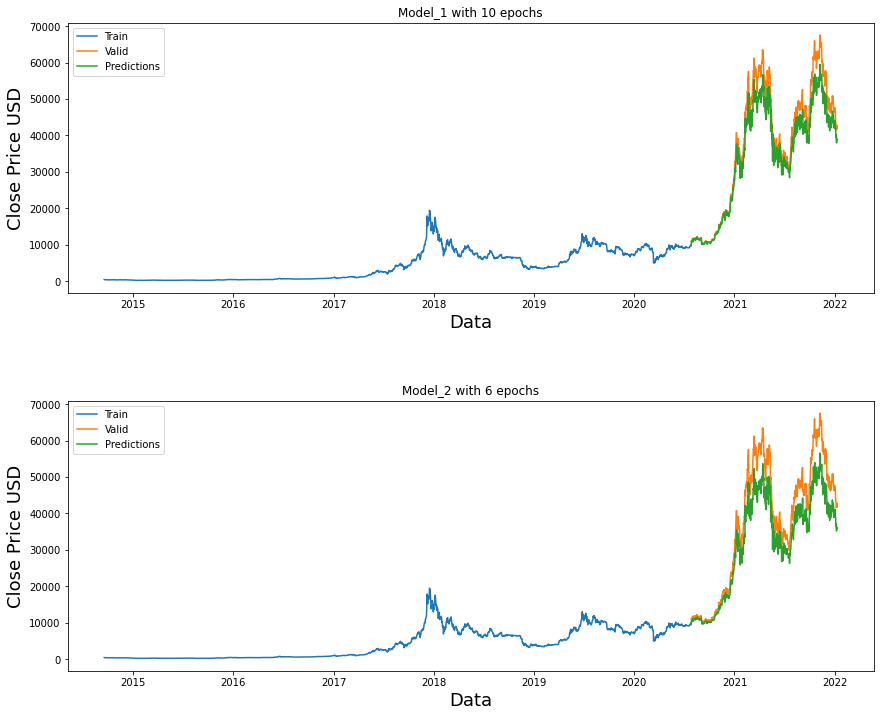

In [ ]:
# Plot the data
train = data[:training_data_len]

#data for model_1
valid_1 = data[training_data_len:]
valid_1['Predictions'] = predictions_1

# data for model_2
valid_2 = data[training_data_len:]
valid_2['Predictions'] = predictions_2

# Visualized the data 
#model_1
plt.figure(figsize=(14, 10))
plt.subplot(2, 1, 1)
plt.title('Model_1 with 10 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

#model_2
plt.subplot(2, 1, 2)
plt.title('Model_2 with 6 epochs')
plt.xlabel('Data', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_2[['Close', 'Predictions']])

plt.legend(['Train', 'Valid', 'Predictions'], loc='upper left')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

It seem's our model_1 has a better predictions than the model_2. So please keep in mind that never choose a model to use, without ploting the result ;)

Now it's time to predict a future day price which is not in train or test set. In other words we want to predict a price out of the dataframe which is the price of today. 

So first we need to create a new variable `last_60_days` and use it to predict the today price of Bitcoin. This way we can create a new test set to creating the price of last 60 days from today (today is 1/15/2022).

In [ ]:
#Get the last 60 day closing price values and convert the datadrame to an array
last_60_days = data[-60:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
# create an empty list
new_X_test = []
# Append the past 60 days
new_X_test.append(last_60_days_scaled)
# Convert the X_test data set to a numpy array
new_X_test = np.array(new_X_test)
# Reshape the data 
new_X_test = np.reshape(new_X_test, (new_X_test.shape[0], new_X_test.shape[1], 1))
# Get the predicted scaled price
pred_price = model_1.predict(new_X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

Here is the today price of bitcoin: 

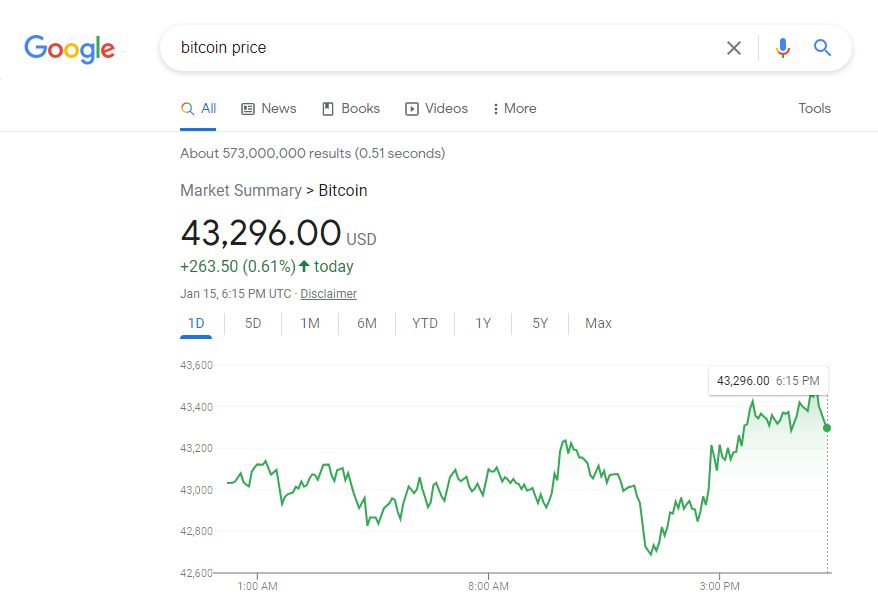

It seems our model did a good job with prediction today price. We might upgrade this model in the future together.

You can improve the model that we write together by doing these steps:

* Increase or decrease the hidden layers
* Increase or decrease the Units per each layer
* Using other types of layer or changing the activation function of the layers
* Train more the model with diffrent batch size and see what will happen

Don't forget that never change many items in your model, because you can't figure it out which of those changes will couse the improvment on to your model. And always using ploting and storing the history of training steps to see what is going on. 

So here is the end of this notebook. I hope you did enjoy and learned something new. 

Don't forget to give me a star if you like this model ;)